In [ ]:
#@markdown # **Install Transformers**
!pip install transformers

In [2]:
#@markdown # **Importing Transformers, Torch , Pil**
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer, BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image
import requests


In [4]:
#@markdown #**Check If GPu is Avaliable or not**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# **model : nlpconnect/vit-gpt2-image-captioning**

In [ ]:
#@markdown **Models 1.nlpconnect/vit-gpt2-image-captioning**

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

model.to(device)

In [7]:
#@markdown #**Funcion to predict text**

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds



In [9]:
path = "/content/sample2.jpg" #@param {type:"string"}
predict_step([path])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


['a man riding a horse on top of a beach']

# **Using Blip**
**2.Salesforce/blip-image-captioning-large**

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")


In [10]:

image_path = '/content/sample2.jpg' #@param {type:"string"}
# Load the image from the specified path
raw_image = Image.open(image_path).convert('RGB')
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print("Conditional :" ,processor.decode(out[0], skip_special_tokens=True))

# Unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print("UnConditional :" ,processor.decode(out[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Conditional : a photography of a man riding a horse on the beach
UnConditional : there is a man riding a horse on the beach


# **Using Blip2 (Requires Hig GPUs)**
**2.Salesforce/blip-image-captioning-large**

In [ ]:
!pip3 install salesforce-lavis
from lavis.models import load_model_and_preprocess

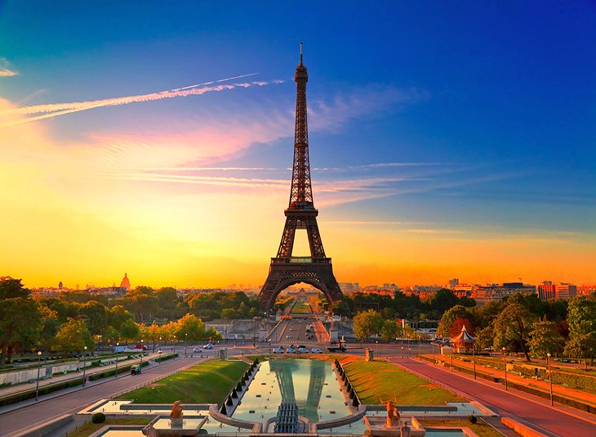

In [24]:
img_url = 'https://www.planetware.com/wpimages/2020/02/france-in-pictures-beautiful-places-to-photograph-eiffel-tower.jpg'  #@param {type:"string"}
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
display(raw_image.resize((596, 437)))

In [ ]:

#     name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device

# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5" #@param {type:"string"}
    ,
    model_type="pretrain_flant5xxl" #@param {type:"string"}
    ,
    is_eval=True,
    device=device
)

vis_processors.keys()

In [ ]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
model.generate({"image": image})

In [ ]:
#@markdown **Generate captions**
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

In [ ]:
model.generate({"image": image, "prompt": "Question: which city is this? Answer:"})

In [ ]:
model.generate({
    "image": image,
    "prompt": "Question: which city is this? Answer: singapore. Question: why?"})

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

In [ ]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)